<a href="https://colab.research.google.com/github/AnastasiaKazanas/ANN-Final-Project/blob/main/BOW_FCNN/TwitterDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import kagglehub
import os

In [2]:
# Kaggle dataset download
path = kagglehub.dataset_download("sudishbasnet/truthseekertwitterdataset2023")
dataset_dir = "/root/.cache/kagglehub/datasets/sudishbasnet/truthseekertwitterdataset2023/"

# Dynamically locate
file_name = None
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if "Truth_Seeker_Model_Dataset" in file and file.endswith(".csv"):
            file_name = os.path.join(root, file)
            break

# Load the dataset
df = pd.read_csv(file_name)

print("Dataset preview:")
print(df.head())

print("\nDataset statistics:")
print(df.describe())

# missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)
df.dropna(subset=['tweet', 'BinaryNumTarget'], inplace=True)

# Rename columns
df.rename(columns={'tweet': 'text', 'BinaryNumTarget': 'label'}, inplace=True)

100%|██████████| 32.2M/32.2M [00:02<00:00, 16.0MB/s]

Extracting files...


Dataset preview:
   Unnamed: 0      author                                          statement  \
0           0  D.L. Davis  End of eviction moratorium means millions of A...   
1           1  D.L. Davis  End of eviction moratorium means millions of A...   
2           2  D.L. Davis  End of eviction moratorium means millions of A...   
3           3  D.L. Davis  End of eviction moratorium means millions of A...   
4           4  D.L. Davis  End of eviction moratorium means millions of A...   

   target  BinaryNumTarget                 manual_keywords  \
0    True              1.0  Americans, eviction moratorium   
1    True              1.0  Americans, eviction moratorium   
2    True              1.0  Americans, eviction moratorium   
3    True              1.0  Americans, eviction moratorium   
4    True              1.0  Americans, eviction moratorium   

                                               tweet 5_label_majority_answer  \
0  @POTUS Biden Blunders - 6 Month Update\n\nInfl

In [3]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

# Add filtering
new_data = []
new_labels = []
for text, label in zip(df['processed_text'], df['label']):
    if len(text) > 50 and text not in new_data:
        new_data.append(text)
        new_labels.append(label)

filtered_df = pd.DataFrame({'text': new_data, 'label': new_labels})

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    filtered_df['text'], filtered_df['label'], test_size=0.2, random_state=42
)


In [4]:
# Tfidf Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

# Convert labels to tensors
train_labels = torch.tensor(train_labels.values, dtype=torch.long)
test_labels = torch.tensor(test_labels.values, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), train_labels)
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [6]:
# Define NN
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 2

model = TextClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# Evaluation
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.numpy())
        y_true.extend(y_batch.numpy())


Epoch 1/10, Loss: 363.3210
Epoch 2/10, Loss: 195.4225
Epoch 3/10, Loss: 135.8344
Epoch 4/10, Loss: 77.9369
Epoch 5/10, Loss: 34.7953
Epoch 6/10, Loss: 12.3948
Epoch 7/10, Loss: 5.1887
Epoch 8/10, Loss: 2.6774
Epoch 9/10, Loss: 1.6558
Epoch 10/10, Loss: 1.2216



Model Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.98      0.98     12760
        True       0.98      0.98      0.98     13735

    accuracy                           0.98     26495
   macro avg       0.98      0.98      0.98     26495
weighted avg       0.98      0.98      0.98     26495



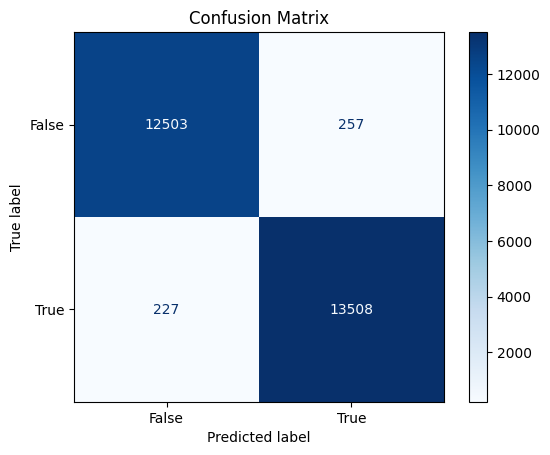


Sample Predictions:

Sample 1
Text: felipemurrelli angobansaor aodhanoriordain lets say the 8th was in place during covid in 2020 there would not have been around 6500 abortions for that year significant less travel to britain in that time with restrictions context and data is left out too as births are decreasing a lot too
Predicted: True, Actual: True

Sample 2
Text: gordonc36148772 rstrongdoctor piersmorgan have you seen what happened to black in china during this covid19 research on africans being kicked out of their homes and forced to sleep on the streets
Predicted: True, Actual: True

Sample 3
Text: according to the nationalcenter for healthstatistics almost 64000 americans died of opioid overdoses in 2016 more than died in the vietnam war an average of 175 people a day
americas addictions opioids trump and war by tomengelhardt
Predicted: True, Actual: True

Sample 4
Text: squawkcnbc jim kramer needs to go  for him to call speaker pelosi crazy nancy is horrendous  i dont give a

In [7]:
accuracy = accuracy_score(y_true, y_pred)
print(f"\nModel Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['False', 'True']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['False', 'True'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Display a few predictions
print("\nSample Predictions:")
for i, (text, pred, true_label) in enumerate(zip(test_texts[:5], y_pred[:5], test_labels[:5])):
    print(f"\nSample {i+1}")
    print(f"Text: {text}")
    print(f"Predicted: {'True' if pred else 'False'}, Actual: {'True' if true_label else 'False'}")